In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

In [4]:
%ls *.csv

airline.csv


In [9]:
air = np.loadtxt('airline.csv')

In [10]:
x = air[: ,0]
y = air[:, 1]
stop = 96

In [11]:
x.shape

(144,)

In [12]:
y.shape

(144,)

In [22]:
from sklearn import preprocessing
import random

random.seed(23)

idx = random.sample(range(len(x)), 50)

x_new = (x - min(x))/(max(x)-min(x))

scaler = preprocessing.StandardScaler().fit(y.reshape(-1,1))

y_new = scaler.transform(y.reshape(-1,1))


#train_gx = x_new[idx][:,None]
#train_gy = y_new[idx] + 0.0001 * np.random.normal(0,1,50)[:,None]

train_x = x_new[:stop][:,None]
train_y = y_new[:stop]

test_x = x_new[stop:][:,None]
test_y = y_new[stop:]

In [23]:
train_x.shape, test_x.shape

((96, 1), (48, 1))

In [24]:
train_y.shape, test_y.shape

((96, 1), (48, 1))

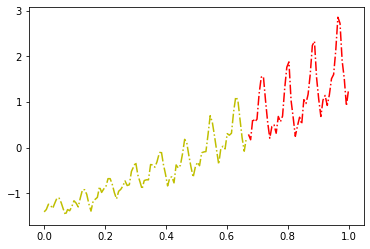

In [26]:
plt.plot(train_x,train_y, 'y-.')
plt.plot(test_x,test_y, 'r-.')

In [27]:
import tensorflow as tf

tf.keras.backend.set_floatx("float64")
tf.get_logger().setLevel("INFO")

In [49]:
import gpflow
import gpflux

num_data = len(train_x)
num_inducing = 23
output_dim = train_y.shape[1]

kernel = gpflow.kernels.SquaredExponential()
inducing_variable = gpflow.inducing_variables.InducingPoints(
    np.linspace(train_x.min(), train_x.max(), num_inducing).reshape(-1, 1)
)
gp_layer = gpflux.layers.GPLayer(
    kernel, inducing_variable, num_data=num_data, num_latent_gps=output_dim
)

In [50]:
num_data, output_dim

(96, 1)

In [51]:
likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))

In [52]:
single_layer_dgp = gpflux.models.DeepGP([gp_layer], likelihood_layer)
model = single_layer_dgp.as_training_model()
model.compile(tf.optimizers.Adam(0.01))

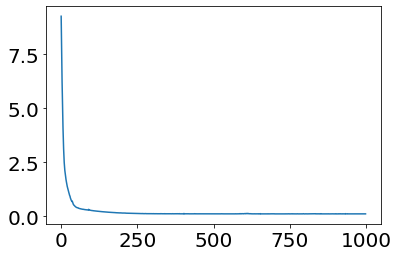

In [53]:
history = model.fit({"inputs": train_x, "targets": train_y}, epochs=int(1e3), verbose=0)
plt.plot(history.history["loss"])

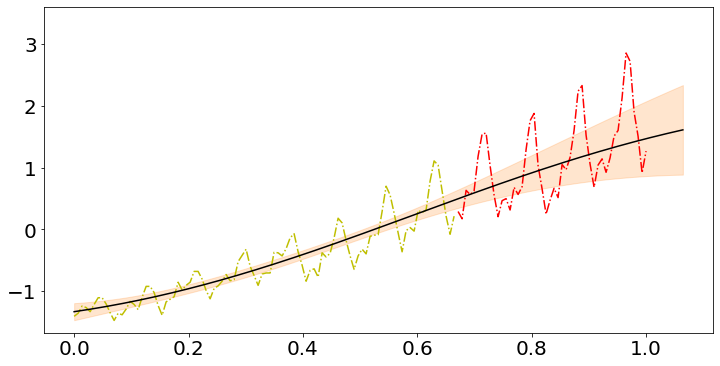

In [54]:
import matplotlib 

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 


def plot(model, X, Y, x_test, y_test, figname, ax=None):
    if ax is None:
        #fig, ax = plt.subplots()
        fig, ax = plt.subplots(figsize=(12, 6))

    a = 0.4
    N_test = 300
    X_test = np.linspace(X.min() , X.max() + a, N_test).reshape(-1, 1)
    out = model(X_test)

    mu = out.f_mean.numpy().squeeze()
    var = out.f_var.numpy().squeeze()
    X_test = X_test.squeeze()
    lower = mu - 1.96 * np.sqrt(var)
    upper = mu + 1.96 * np.sqrt(var)
    
    #ax.rcParams["figure.figsize"] = (20,3)

    ax.set_ylim(Y.min() - 0.2, Y.max() + 2.5)
    ax.plot(X, Y, "y-.")
    ax.plot(x_test,y_test,'r-.')
    ax.plot(X_test, mu, 'k-',linewidth=1.5)

    ax.fill_between(X_test, lower, upper, color="C1", alpha=0.2)
    fig.savefig(figname, bbox_inches='tight')


plot(single_layer_dgp.as_prediction_model(), train_x[:,0], train_y[:,0], test_x[:,0], test_y[:,0],"gp_airline.pdf")

In [55]:
single_layer_dgp.elbo((train_x, train_y))

<tf.Tensor: shape=(), dtype=float64, numpy=-10.80687627076551>

In [56]:
Z = np.linspace(train_x.min(), train_x.max(), num_inducing).reshape(-1, 1)
kernel1 = gpflow.kernels.SquaredExponential()
inducing_variable1 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer1 = gpflux.layers.GPLayer(
    kernel1, inducing_variable1, num_data=num_data, num_latent_gps=output_dim
)

kernel2 = gpflow.kernels.SquaredExponential()
inducing_variable2 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer2 = gpflux.layers.GPLayer(
    kernel2,
    inducing_variable2,
    num_data=num_data,
    num_latent_gps=output_dim,
    mean_function=gpflow.mean_functions.Zero(),
)

kernel3 = gpflow.kernels.SquaredExponential()
inducing_variable3 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer3 = gpflux.layers.GPLayer(
    kernel3,
    inducing_variable3,
    num_data=num_data,
    num_latent_gps=output_dim,
    mean_function=gpflow.mean_functions.Zero(),
)

likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))
two_layer_dgp = gpflux.models.DeepGP([gp_layer1, gp_layer2], likelihood_layer)
model = two_layer_dgp.as_training_model()
model.compile(tf.optimizers.Adam(0.01))

In [57]:
history = model.fit({"inputs": train_x, "targets": train_y}, epochs=int(2e3), verbose=0)

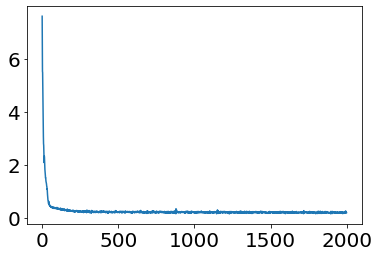

In [58]:
plt.plot(history.history["loss"])

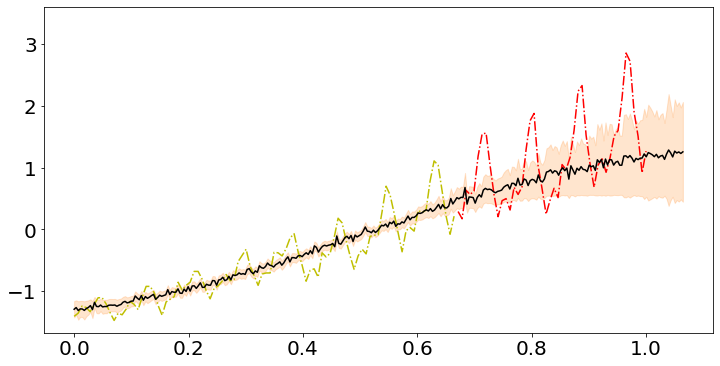

In [59]:
plot(two_layer_dgp.as_prediction_model(), train_x[:,0], train_y[:,0],test_x[:,0],test_y[:,0],'dgp_airline.pdf')

In [60]:
two_layer_dgp.elbo((train_x, train_y))

<tf.Tensor: shape=(), dtype=float64, numpy=-16.138221527328994>

In [61]:
three_layer_dgp = gpflux.models.DeepGP([gp_layer1, gp_layer2, gp_layer3], likelihood_layer)
model3 = three_layer_dgp.as_training_model()
model3.compile(tf.optimizers.Adam(0.01))

In [62]:
history = model3.fit({"inputs": train_x, "targets": train_y}, epochs=int(2e3), verbose=0)

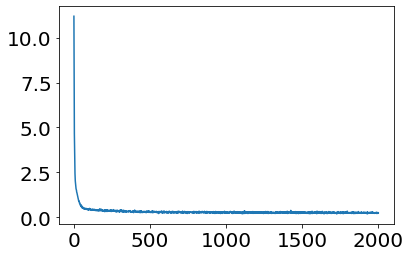

In [63]:
plt.plot(history.history["loss"])

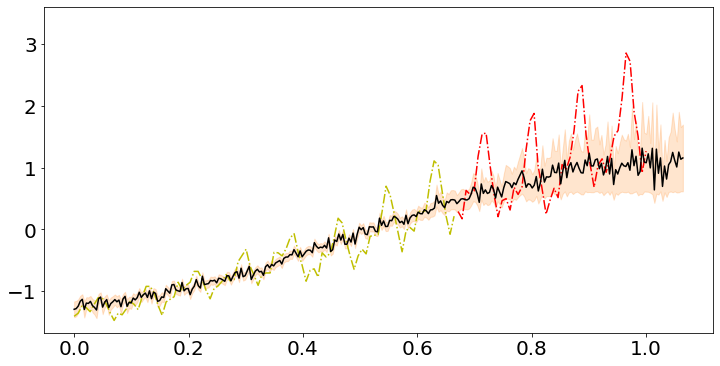

In [64]:
plot(three_layer_dgp.as_prediction_model(), train_x[:,0], train_y[:,0],test_x[:,0],test_y[:,0],'dgp3_airline.pdf')

In [65]:
three_layer_dgp.elbo((train_x, train_y))

<tf.Tensor: shape=(), dtype=float64, numpy=-25.54538310500855>